In [1]:
from openvino.inference_engine import IECore
import matplotlib.pyplot as plt
import cv2
import numpy as np
ie = IECore()

In [4]:
Video_path = r'data_videos\1234.mp4'
video_capture = cv2.VideoCapture(Video_path)

# Specify the desired window size
window_width = 800
window_height = 600

while True:
    ret, frame = video_capture.read()
        
    if not ret:
        break  
    
    # Resize the frame to fit within the window size
    frame = cv2.resize(frame, (window_width, window_height))
    
    cv2.imshow('License Plate Detection', frame)        
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break
    
video_capture.release()
cv2.destroyAllWindows()


In [2]:
def show(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [3]:
image_path = r'data_images\normal-people-1024x576.jpeg'
image = cv2.imread(image_path)

In [4]:
def Face_Detection(image):
    model_xml = r'models\face-detection-adas-0001\face-detection-adas-0001.xml'
    model_bin = r'models\face-detection-adas-0001\face-detection-adas-0001.bin'
    net = ie.read_network(model=model_xml, weights=model_bin)
    exec_net = ie.load_network(network=net, device_name='CPU')
    input_name = next(iter(net.input_info))
    input_info = net.input_info[input_name]
    n, c, h, w = input_info.tensor_desc.dims
    resized_image = cv2.resize(image, (w, h))
    input_data = resized_image.transpose((2, 0, 1))
    output = exec_net.infer(inputs={input_name: input_data})

    # Process the output data
    output_name = next(iter(net.outputs))
    output_data = output[output_name]
    boxes = output_data[0][0]  # Assuming a single image was processed



    # Loop through the detected faces and draw bounding boxes on the image
    Number_Of_Faces = 0
    for box in boxes:
        confidence = box[2]
        if confidence > 0.5:  # Filter detections based on confidence threshold
            Number_Of_Faces += 1
            x_min = int(box[3] * image.shape[1])
            y_min = int(box[4] * image.shape[0])
            x_max = int(box[5] * image.shape[1])
            y_max = int(box[6] * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    show(image)
    # Display the image with bounding boxes
    if Number_Of_Faces==0:
        Number_Of_Faces = 1
    return boxes, Number_Of_Faces


In [5]:
def show_points(image,boxes,Number_Of_Faces):    
    model_xml_landmarks = r'models\facial-landmarks-35-adas-0002\facial-landmarks-35-adas-0002.xml'
    model_bin_landmarks = r'models\facial-landmarks-35-adas-0002\facial-landmarks-35-adas-0002.bin'
    net_landmarks = ie.read_network(model=model_xml_landmarks, weights=model_bin_landmarks)
    exec_net_landmarks = ie.load_network(network=net_landmarks, device_name='CPU')

    # Prepare input data for the facial landmarks detection model
    input_name_landmarks = next(iter(net_landmarks.input_info))
    input_info_landmarks = net_landmarks.input_info[input_name_landmarks]
    n_landmarks, c_landmarks, h_landmarks, w_landmarks = input_info_landmarks.tensor_desc.dims
    mark = []
 

    for i in range(Number_Of_Faces):
        face_box = boxes[i]  # Assuming only one face is detected
        
        x_min = int(face_box[3] * image.shape[1])
        y_min = int(face_box[4] * image.shape[0])
        x_max = int(face_box[5] * image.shape[1])
        y_max = int(face_box[6] * image.shape[0])

        face_image = image[y_min:y_max, x_min:x_max]
        face_resized = cv2.resize(face_image, (w_landmarks, h_landmarks))
        input_data_landmarks = face_resized.transpose((2, 0, 1))
        output_landmarks = exec_net_landmarks.infer(inputs={input_name_landmarks: input_data_landmarks})

        # Process the output of the facial landmarks detection model
        output_name_landmarks = next(iter(net_landmarks.outputs))
        landmarks = output_landmarks[output_name_landmarks]
        # Reshape the landmarks into pairs of x and y coordinates
        count = 0
        points = 0
        
        landmarks_xy = landmarks.reshape(-1, 2)
        for landmark in landmarks_xy:
            x, y = landmark
            
            # Apply scaling factor to make the landmarks more visible
            x = int(x * (x_max - x_min) + x_min)
            y = int(y * (y_max - y_min) + y_min)
            if count<4:
             mark.append(x)
             mark.append(y)
             count+=1
            plt.scatter(x, y, c='red', s=5)
            points+=1  # Plot each landmark as a red dot


    show(image)
    return mark

In [158]:
def Eye_Detection(image):
    gray_scale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray_scale = cv2.GaussianBlur(gray_scale , (7,7) ,0)
    _, threshold = cv2.threshold(gray_scale,48,255,cv2.THRESH_BINARY_INV)
    contours , _ = cv2.findContours(threshold ,cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours: 
        cv2.drawContours(gray_scale,[cnt],-1,(0,0,255),3)
    show(gray_scale)

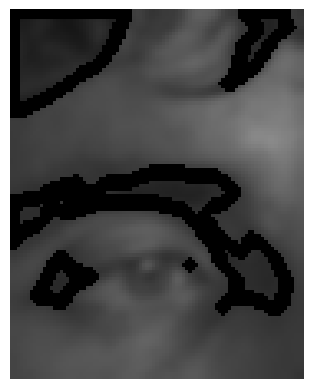

In [159]:
Eye_Detection(left_eye)

In [107]:
def head_pose_angles(image):
    head_pose_xml = r'models\head-pose-estimation-adas-0001\head-pose-estimation-adas-0001.xml'
    head_pose_bin = r'models\head-pose-estimation-adas-0001\head-pose-estimation-adas-0001.bin'
    net_head_pose = ie.read_network(model = head_pose_xml,weights = head_pose_bin)
    ext_head_pose = ie.load_network(network = net_head_pose,device_name='CPU')
    input_name = next(iter(net_head_pose.input_info))
    input_info = net_head_pose.input_info[input_name]
    n_landmarks, c_landmarks, h_landmarks, w_landmarks = input_info.tensor_desc.dims
    head_resized = cv2.resize(image,(60,60))
    preprocessed_image = head_resized.transpose((2, 0, 1)) 
    output = ext_head_pose.infer(inputs={input_name: preprocessed_image})
    yaw = output['angle_y_fc'].flatten()[0]  # Extract the yaw angle value
    pitch = output['angle_p_fc'].flatten()[0]  # Extract the pitch angle value
    roll = output['angle_r_fc'].flatten()[0]  # Extract the roll angle valu4
    return yaw,pitch,roll

In [59]:
def left_eye(image, First, Second):
    # Determine the minimum and maximum x-coordinates of the eye region
    x_max, x_min = max(First[0], First[1]), min(First[0], First[1])
    
    # Determine the minimum and maximum y-coordinates of the eye region
    y_max, y_min = max(Second[0], Second[1]), min(Second[0], Second[1])
    
    # Define fixed offsets for the eye region
    x_offset = 30
    y_offset = 30
    
    # Adjust the coordinates using the fixed offsets
    x_min -= x_offset
    x_max += x_offset
    y_min -= y_offset
    y_max += y_offset
    

    
    # Extract the eye region from the image
    eye_region = image[y_min-50:y_max, x_min:x_max]
    
    return eye_region

def right_eye(image, Third, Fourth):
    # Determine the minimum and maximum x-coordinates of the eye region
    x_max, x_min = max(Third[0], Third[1]), min(Third[0], Third[1])
    
    # Determine the minimum and maximum y-coordinates of the eye region
    y_max, y_min = max(Fourth[0], Fourth[1]), min(Fourth[0], Fourth[1])
    
    # Define fixed offsets for the eye region
    x_offset = 30
    y_offset = 30
    
    # Adjust the coordinates using the fixed offsets
    x_min -= x_offset
    x_max += x_offset
    y_min -= y_offset
    y_max += y_offset
    
    
    # Extract the eye region from the image
    eye_region = image[y_min:y_max, x_min:x_max]
    
    return eye_region




def make_arrow(image,start_point, vector):
    # Calculate the end point of the arrow
    end_point = (start_point[0] + vector[0], start_point[1] + vector[1])

    # Calculate the normalized vector in relation to the starting point
    diff_x = end_point[0] - start_point[0]
    diff_y = end_point[1] - start_point[1]
    magnitude = np.linalg.norm([diff_x, diff_y])
    normalized_vector = [diff_x / magnitude, diff_y / magnitude]

    # Scale down the vector to ensure visibility
    scale_factor = 10 # Adjust this factor as needed
    scaled_vector = [normalized_vector[0] * scale_factor, normalized_vector[1] * scale_factor]
  

    # Create a figure and axis
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Plot the arrow
    ax.arrow(start_point[0], start_point[1],
             scaled_vector[0], scaled_vector[1],
             head_width=18, head_length=100,
             fc='red', ec='red')

    ax.set_aspect('equal')
    plt.show()


   

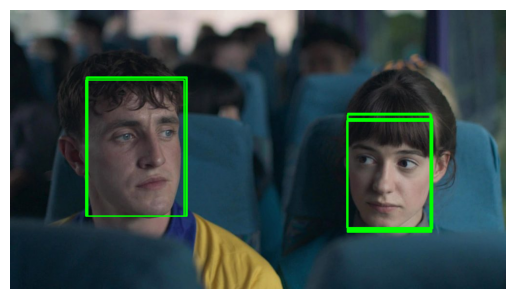

In [60]:
boxes , Number_Of_Faces= Face_Detection(image)

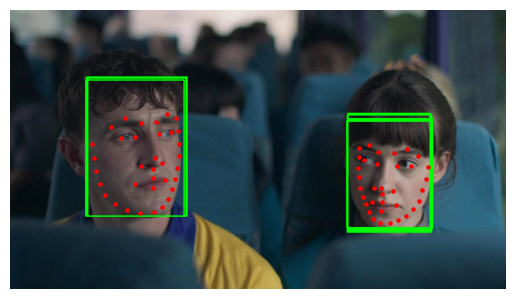

In [61]:
landmarks_xy = show_points(image, boxes, Number_Of_Faces)

In [62]:
def capture_eyes(landmarks_xy):
    first = landmarks_xy[:3:2]
    secound = landmarks_xy[1:4:2]
    third = landmarks_xy[4:7:2]
    fourth = landmarks_xy[5::2]
    left_eye1 = left_eye(image,first,secound)
    right_eye1 = right_eye(image,third,fourth)
    eye_center_left = (int((first[0]+first[1])/2), int((secound[0]+secound[1])/2))
    eye_center_right =  (int((third[0]+third[1])/2), int((fourth[0]+fourth[1])/2))
    return eye_center_left, eye_center_right ,left_eye1,right_eye1

In [63]:
eye_center_left,eye_center_right ,left_eye,right_eye = capture_eyes(landmarks_xy)
yaw , pitch , roll = head_pose_angles(image)

In [64]:
Eye_Detection(right_eye)

'closed'

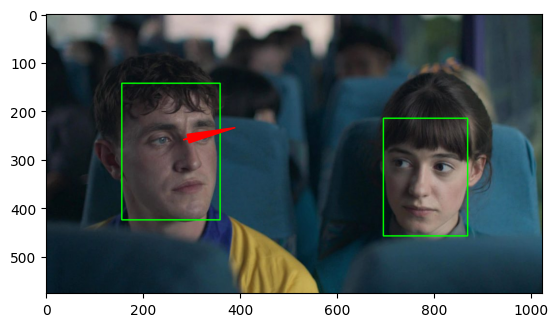

In [14]:
def make_gaze():
    gaze_xml = r'models\gaze-estimation-adas-0002\gaze-estimation-adas-0002.xml'
    gaze_bin = r'models\gaze-estimation-adas-0002\gaze-estimation-adas-0002.bin'
    net_gaze = ie.read_network(model=gaze_xml, weights=gaze_bin)
    ext_gaze = ie.load_network(network=net_gaze, device_name='CPU')
    input_name = next(iter(net_gaze.input_info))
    input_info = net_gaze.input_info[input_name]

    right_eye_image_resized = cv2.resize(right_eye, (60, 60))
    right_eye_input = right_eye_image_resized.transpose((2, 0, 1)) 

    # Perform gaze estimation for the left eye
    left_eye_image_resized = cv2.resize(left_eye, (60, 60))
    left_eye_input = left_eye_image_resized.transpose((2, 0, 1))  # Transpose to B, C, H, W format
    output_left = ext_gaze.infer(inputs={'right_eye_image': right_eye_input,'left_eye_image': left_eye_input, 'head_pose_angles': [yaw, pitch, roll]})
    gaze_vector = output_left['gaze_vector'].flatten()
    left_eye_center = eye_center_left
    right_eye_center = eye_center_right




    combined_center =  ((x + y) / 2 for x, y in zip(left_eye_center, right_eye_center))
    make_arrow(image,tuple(combined_center),gaze_vector[:2])